In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
from time import time
import matplotlib.pyplot as plt
import math
%matplotlib inline

Use a colorblind color palette for plotting.

In [2]:
plt.style.use('tableau-colorblind10')

Read in the data set.

In [3]:
df = pd.read_csv("../2131-2208_cleaned.csv") # Fall 2013 - Summer 2021

/Users/aewsma/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (7,8,9,10,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Read in the LA course informtion from Emily

In [4]:
LAdf = pd.read_csv("../LA_Courses_2205_23Mar2022.csv")
LAdf.rename(columns={"term":"Term"}, inplace=True)

The following changes Pandas options when displaying the DataFrame so that it doesn't give a "..." when there are too many columns.

In [5]:
pd.set_option("display.max_columns", 40, "display.max_rows", 200)

Note: these forms of the `compute_matrix` function assume that we are working with the LA data"

These versions account for partial data cohorts (e.g., the current Fall 2019 cohort, since they have not had 6 full years yet in the DataFrame)
  * uses a series of `if` statements to determine whether to proceed with calculating subsequent rows (year-to-year transitions) within the numbers matrix. Note that years where there is no data are left as 0s, so normalizing will give infinities/nans. Need to account for that on the user side by only adding these partial data fellas to matrices from cohort terms where we have enough data to estimate those entries
  
`compute_matrix_orig` (lower) is the original code from Mason/Tiana.
* takes in a DataFrame and `cohort_term`,
* grabs all students from that `cohort_term` who took classes during that term (misses transfer students)
* compute the "persisters" from Year N to N+1 as the subset of students from Year N who take classes in Year N+1 **OR** who have a `degree_term` that is after Year N.
  * those who have a `degree_term` in Year N go into the N-->depart (degree) transition numbers
  * those who no longer take classes **and** do not eventually obtain a degree go into the N-->depart (no degree) transition numbers
* only would account for students who have LAs during their first year (`cohort_term` or the following spring)
  * this original version is not adapted for the LA analysis in any specific way

`compute_matrix_tw` is modified by Tony to adapt for the LA analysis
* accounts for students who have LAs in years besides their first year 
  * does this by (eg) checking who had LAs during their second year (relative to `cohort_term`), but were not already in the DataFrame from Year 1 (by virtue of having had LAs during Year 1). then does this for Years 2-6 too.

In [6]:
def compute_matrix_tw(df, cohort_term): 
    '''
    This version is adding in students who have LAs in years 2-6 to 
    the students who have persisted from previous years.
    '''

    # Set up initial matrix for numbers of students making each transition (from row i to column j)
    mat = np.zeros((8,8))
    
    # Check that there's data to at least calculate Y1-->Y2 transitions
    if len(df.loc[(df["Term"]>=cohort_term+10) & (df["Term"]<cohort_term+20)])==0:
        print("WARNING: Insufficient data to calculate any transitions. Ending.")
        return

    #===========================================================================
    # YEAR 1 CALCULATION 
    #===========================================================================
  
    # Find all the IDs of students in the specified cohort that were at RIT for the first year
    # Includes students who start/have LAs in fall or spring of their first year
    IDY1 = df.loc[(df["Cohort Term"] == cohort_term) & 
                  ((df["Term"] == cohort_term) | (df["Term"] == cohort_term+4)), "ID"].unique()
    # Save a new dataframe, dfY1, that just has those IDs, for all years they show up total
    dfY1 = df.loc[df["ID"].isin(IDY1)]

    #===========================================================================
    # YEAR 1 -> 2 CALCULATION AND TRANSITIONS
    #===========================================================================
    
    #Which of the Y1 IDs appear again in a future year? If they show up in the data for a second year (not necessarily right after the first year), they'll get pulled here into this other new dataframe, dfY2
    IDY2 = dfY1.loc[(dfY1["Term"]>=cohort_term +10) | (dfY1["Degree Term"]>=cohort_term +10), "ID"].unique() 
    # to get mat[0,1] = Y1->Y2 transition, only want persisters
    dfY2 = dfY1.loc[dfY1["ID"].isin(IDY2)]
    mat[0,1] = len(dfY2["ID"].unique()) 

    #Now we want the difference between those in Y1 and those in Y2. Presumably, if they're in Y1 but don't return for another year in the data, they have either graduated or left the program
    Y1_set = set(dfY1["ID"]) 
    Y2_set = set(dfY2["ID"]) 
    departures = set.difference(Y1_set, Y2_set) 

    #Now grab all the data for the IDs that stop appearing after Y1, which we're assuming means they only spent one year at RIT
    Y1_depart = dfY1.loc[dfY1["ID"].isin(departures)]
    #Out of those, we want to distinguish the IDs with any "Degree Term" listed during or after first year, which implies they graduated rather than dropping out
    Y1_degree = Y1_depart.loc[(Y1_depart["Degree Term"] >= cohort_term) | (Y1_depart["Degree Term"] < cohort_term)]

    # Total number of students who stop appearing after Y1, without any degree listed. 
    mat[0,6] = (len(departures))-len(Y1_degree["ID"].unique())
    # Total number of students who stop appearing after Y1, and have a degree listed, so we categorize them as graduates
    mat[0,7] = len(Y1_degree["ID"].unique())

    #===========================================================================
    # YEAR 2 -> 3 CALCULATION AND TRANSITIONS
    #===========================================================================

    if len(df.loc[(df["Term"]>=cohort_term+20) & (df["Term"]<cohort_term+30)])>0:
        # only continue if we have data. otherwise, leave as 0s
        
        # ***** begin changes to account for LA-having (and changing dfYX --> dfYXc) *****
        # Now the starters for Y2 should include persisters from Y1 (dfY2) AND the
        # students from the desired cohort_term who have LAs in their second year, AND
        # who were not in the Y1 dataframe.
        # Concatenate the persisters from Y1 with those from the desired cohort_term who have LAs in their second year
        # Note that we can remove the `LAexperience` constraint and this will effectively be accounting for transfer students
        IDY2LAs = df.loc[(df["Cohort Term"]==cohort_term) & 
                         ((df["Term"]>=cohort_term+10) & (df["Term"]<cohort_term+20)) &
                         (~df["ID"].isin(Y1_set)) & (df["LAexperience"]==1),"ID"].unique()
        IDadd = set.difference(set(IDY2LAs),Y1_set)
        dfY2LAs = df.loc[(df["Term"]>=cohort_term+10) &
                         (df["Cohort Term"]==cohort_term) & (df["ID"].isin(IDadd))]

        # Here is where we can concatenate the dfY2 DataFrame with the above
        dfY2c = pd.concat([dfY2,dfY2LAs],ignore_index=True)
        # Need to reset the set of IDs
        Y2_set = set(dfY2c["ID"]) 
        # ***** end changes to account for LA-having (and changing dfYX --> dfYXc) *****

        #Which of the Y2 IDs appear again in a future year? If they show up in the data for a third year (not necessarily right after the second year), they'll get pulled here into dfY3
        IDY3 = dfY2c.loc[(dfY2c["Term"]>=cohort_term+20)|(dfY2c["Degree Term"]>=cohort_term+20), "ID"].unique() 
        dfY3 = dfY2c.loc[dfY2c["ID"].isin(IDY3)]
        mat[1,2] = len(dfY3["ID"].unique())

        #Find the difference between those in Y2 and those in Y3. We're assuming the IDs in Y2 but not Y3 left RIT after their second year
        Y3_set = set(dfY3["ID"])
        departures = set.difference(Y2_set, Y3_set) 

        #Now grab all the data for the IDs that stop appearing after Y2, which we're assuming means they only spent two years at RIT
        Y2_depart = dfY2c.loc[dfY2c["ID"].isin(departures)]

        #Distinguish the IDs with any "Degree Term" listed during or after second year, which implies they graduated
        Y2_degree = Y2_depart.loc[(Y2_depart["Degree Term"]>=cohort_term) & (Y2_depart["Degree Term"]<cohort_term+20)] 

        #Total number of students who stop appearing after a second year, without any degree listed 
        mat[1,6] = len(departures) - len(Y2_degree["ID"].unique())

        #Total number of students who stop appearing after a second year, and have a degree listed
        mat[1,7] = len(Y2_degree["ID"].unique())

    ##### Repeat this process for up to 6 years. This should give us a model esitmating the numbers of students who appear at RIT, leave RIT, and graduate for an indicated cohort

        #===========================================================================
        # YEAR 3 -> 4 CALCULATION AND TRANSITIONS
        #===========================================================================

        if len(df.loc[(df["Term"]>=cohort_term+30) & (df["Term"]<cohort_term+40)])>0:
            # only continue if we have data. otherwise, leave as 0s

            # ***** begin changes to account for LA-having (and changing dfYX --> dfYXc) *****
            # Now the starters for Y3 should include persisters from Y2 (dfY3) AND the
            # students from the desired cohort_term who have LAs in their third year, AND
            # who were not in the Y2 dataframe already.
            # Concatenate the persisters from Y2 with those from the desired cohort_term who have LAs in their third year
            IDY3LAs = df.loc[(df["Cohort Term"]==cohort_term) & 
                             ((df["Term"]>=cohort_term+20) & (df["Term"]<cohort_term+30)) &
                             (~df["ID"].isin(Y2_set)) & (df["LAexperience"]==1),"ID"].unique()
            IDadd = set.difference(set(IDY3LAs),Y2_set)
            dfY3LAs = df.loc[(df["Term"]>=cohort_term+20) &
                             (df["Cohort Term"]==cohort_term) & (df["ID"].isin(IDadd))]

            # Here is where we can concatenate the dfY3 DataFrame with the above
            dfY3c = pd.concat([dfY3,dfY3LAs],ignore_index=True)
            # Need to reset the set of IDs
            Y3_set = set(dfY3c["ID"]) 
            # ***** end changes to account for LA-having (and changing dfYX --> dfYXc) *****

            IDY4 = dfY3c.loc[(dfY3c["Term"]>=cohort_term+30) | (dfY3c["Degree Term"]>=cohort_term+30), "ID"].unique() 
            dfY4 = dfY3c.loc[dfY3c["ID"].isin(IDY4)]
            mat [2,3] = len(dfY4["ID"].unique())
            Y4_set = set(dfY4["ID"]) 
            departures = set.difference(Y3_set, Y4_set) 
            Y3_depart = dfY3c.loc[dfY3c["ID"].isin(departures)]
            Y3_degree = Y3_depart.loc[(Y3_depart["Degree Term"]>=cohort_term) & (Y3_depart["Degree Term"]<cohort_term+30)]
            mat[2,6] = len(departures) - len(Y3_degree["ID"].unique())
            mat[2,7] = len(Y3_degree["ID"].unique())

            #===========================================================================
            # YEAR 4 -> 5 CALCULATION AND TRANSITIONS
            #===========================================================================

            if len(df.loc[(df["Term"]>=cohort_term+40) & (df["Term"]<cohort_term+50)])>0:
                # only continue if we have data. otherwise, leave as 0s

                # ***** begin changes to account for LA-having (and changing dfYX --> dfYXc) *****
                # Now the starters for Y4 should include persisters from Y3 (dfY4) AND the
                # students from the desired cohort_term who have LAs in their fourth year, AND
                # who were not in the Y3 dataframe already.
                # Concatenate the persisters from Y3 with those from the desired cohort_term who have LAs in their fourth year
                IDY4LAs = df.loc[(df["Cohort Term"]==cohort_term) & 
                                 ((df["Term"]>=cohort_term+30) & (df["Term"]<cohort_term+40)) &
                                 (~df["ID"].isin(Y3_set)) & (df["LAexperience"]==1),"ID"].unique()
                IDadd = set.difference(set(IDY4LAs),Y3_set)
                dfY4LAs = df.loc[(df["Term"]>=cohort_term+30) &
                                 (df["Cohort Term"]==cohort_term) & (df["ID"].isin(IDadd))]

                # Here is where we can concatenate the dfY4 DataFrame with the above
                dfY4c = pd.concat([dfY4,dfY4LAs],ignore_index=True)
                # Need to reset the set of IDs
                Y4_set = set(dfY4c["ID"]) 
                # ***** end changes to account for LA-having (and changing dfYX --> dfYXc) *****

                IDY5 = dfY4c.loc[(dfY4c["Term"]>=cohort_term+40) | (dfY4c["Degree Term"]>=cohort_term+40), "ID"].unique()
                dfY5 = dfY4c.loc[dfY4c["ID"].isin(IDY5)]
                mat[3,4] = len(dfY5["ID"].unique())
                Y5_set = set(dfY5["ID"]) 
                departures = set.difference(Y4_set, Y5_set) 
                Y4_depart = dfY4c.loc[dfY4c["ID"].isin(departures)]
                Y4_degree = Y4_depart.loc[(Y4_depart["Degree Term"]>=cohort_term) & (Y4_depart["Degree Term"]<cohort_term+40)]
                mat[3,6] = len(departures) - len(Y4_degree["ID"].unique())
                mat[3,7] = len(Y4_degree["ID"].unique())

                #===========================================================================
                # YEAR 5 -> 6 CALCULATION AND TRANSITIONS
                #===========================================================================
                
                if len(df.loc[(df["Term"]>=cohort_term+50) & (df["Term"]<cohort_term+60)])>0:
                    # only continue if we have data. otherwise, leave as 0s

                    # ***** begin changes to account for LA-having (and changing dfYX --> dfYXc) *****
                    # Now the starters for Y5 should include persisters from Y4 (dfY5) AND the
                    # students from the desired cohort_term who have LAs in their fifth year, AND
                    # who were not in the Y4 dataframe already.
                    # Concatenate the persisters from Y4 with those from the desired cohort_term who have LAs in their fifth year
                    IDY5LAs = df.loc[(df["Cohort Term"]==cohort_term) & 
                                     ((df["Term"]>=cohort_term+40) & (df["Term"]<cohort_term+50)) &
                                     (~df["ID"].isin(Y4_set)) & (df["LAexperience"]==1),"ID"].unique()
                    IDadd = set.difference(set(IDY5LAs),Y5_set)
                    dfY5LAs = df.loc[(df["Term"]>=cohort_term+40) &
                                     (df["Cohort Term"]==cohort_term) & (df["ID"].isin(IDadd))]

                    # Here is where we can concatenate the dfY5 DataFrame with the above
                    dfY5c = pd.concat([dfY5,dfY5LAs],ignore_index=True)
                    # Need to reset the set of IDs
                    Y5_set = set(dfY5c["ID"]) 
                    # ***** end changes to account for LA-having (and changing dfYX --> dfYXc) *****

                    IDY6 = dfY5c.loc[(dfY5c["Term"]>=cohort_term+50) | (dfY5c["Degree Term"]>=cohort_term+50), "ID"].unique() 
                    dfY6 = dfY5c.loc[dfY5c["ID"].isin(IDY6)]   
                    mat[4,5] = len(dfY6["ID"].unique())
                    Y6_set = set(dfY6["ID"]) 
                    departures = set.difference(Y5_set,Y6_set) 
                    Y5_depart = dfY5c.loc[dfY5c["ID"].isin(departures)]
                    Y5_degree = Y5_depart.loc[(Y5_depart["Degree Term"]>=cohort_term) & (Y5_depart["Degree Term"]<cohort_term+50)]
                    mat[4,6] = len(departures) - len(Y5_degree["ID"].unique())
                    mat[4,7] = len(Y5_degree["ID"].unique())

                    #===========================================================================
                    # YEAR 6-> DEPARTURE AND OTHER CALCULATIONS
                    #===========================================================================
                    #if len(df.loc[(df["Term"]>=cohort_term+60) & (df["Term"]<cohort_term+70)])>0:
                    # only continue if we have data. otherwise, leave as 0s
                    # Y6 is a little different, because we only care about whether a degree is 
                    # obtained before (<) cohort_term+60. So, don't need to check farther out.

                    # ***** begin changes to account for LA-having (and changing dfYX --> dfYXc) *****
                    # Now the starters for Y6 should include persisters from Y5 (dfY6) AND the
                    # students from the desired cohort_term who have LAs in their sixth year, AND
                    # who were not in the Y5 dataframe already.
                    # Concatenate the persisters from Y5 with those from the desired cohort_term who have LAs in their sixth year
                    IDY6LAs = df.loc[(df["Cohort Term"]==cohort_term) & 
                                     ((df["Term"]>=cohort_term+50) & (df["Term"]<cohort_term+60)) &
                                     (~df["ID"].isin(Y5_set)) & (df["LAexperience"]==1),"ID"].unique()
                    IDadd = set.difference(set(IDY6LAs),Y6_set)
                    dfY6LAs = df.loc[(df["Term"]>=cohort_term+50) &
                                     (df["Cohort Term"]==cohort_term) & (df["ID"].isin(IDadd))]

                    # Here is where we can concatenate the dfY5 DataFrame with the above
                    dfY6c = pd.concat([dfY6,dfY6LAs],ignore_index=True)
                    # Need to reset the set of IDs
                    Y6_set = set(dfY6c["ID"]) 
                    # ***** end changes to account for LA-having (and changing dfYX --> dfYXc) *****

                    #Y6_degree = dfY6.loc[(dfY6["Degree Term"]>=cohort_term) & (dfY6["Degree Term"]<cohort_term+60)]
                    Y6_degree = dfY6c.loc[(dfY6c["Degree Term"] == cohort_term+50) | (dfY6c["Degree Term"] == cohort_term+54) | (dfY6c["Degree Term"] == cohort_term+57)]
                    mat[5,6] = len(dfY6c["ID"].unique()) - len(Y6_degree["ID"].unique())
                    mat[5,7] = len(Y6_degree["ID"].unique())

    mat[6,6] = 1
    mat[7,7] = 1

    #===========================================================================
    #NOTES: years aren't necessarily consecutive, and this model excludes transfers

    return mat

#===========================================================================
#===========================================================================

def compute_matrix_orig(df, cohort_term): 

    # Set up initial matrix for numbers of students making each transition (from row i to column j)
    mat = np.zeros((8,8))

    # Check that there's data to at least calculate Y1-->Y2 transitions
    if len(df.loc[(df["Term"]>=cohort_term+10) & (df["Term"]<cohort_term+20)])==0:
        print("WARNING: Insufficient data to calculate any transitions. Ending.")
        return

    #===========================================================================
    # YEAR 1 CALCULATION 
    #===========================================================================
  
    # Find all the IDs of students in the specified cohort that were at RIT for the first year
    IDY1 = df.loc[(df["Cohort Term"] == cohort_term) & (df["Term"] == cohort_term), "ID"].unique()
    # Save a new dataframe, dfY1, that just has those IDs, for all years they show up total
    dfY1 = df.loc[df["ID"].isin(IDY1)]

    #===========================================================================
    # YEAR 1 -> 2 CALCULATION AND TRANSITIONS
    #===========================================================================
    
    #Which of the Y1 IDs appear again in a future year? If they show up in the data for a second year (not necessarily right after the first year), they'll get pulled here into this other new dataframe, dfY2
    IDY2 = dfY1.loc[(dfY1["Term"]>=cohort_term +10) | (dfY1["Degree Term"]>=cohort_term +10), "ID"].unique()  
    dfY2 = dfY1.loc[dfY1["ID"].isin(IDY2)]
    mat[0,1] = len(dfY2["ID"].unique()) 

    #Now we want the difference between those in Y1 and those in Y2. Presumably, if they're in Y1 but don't return for another year in the data, they have either graduated or left the program
    Y1_set = set(dfY1["ID"]) 
    Y2_set = set(dfY2["ID"]) 
    departures = set.difference(Y1_set, Y2_set) 

    #Now grab all the data for the IDs that stop appearing after Y1, which we're assuming means they only spent one year at RIT
    Y1_depart = dfY1.loc[dfY1["ID"].isin(departures)]

    #Out of those, we want to distinguish the IDs with any "Degree Term" listed during or after first year, which implies they graduated rather than dropping out
    Y1_degree = Y1_depart.loc[(Y1_depart["Degree Term"] >= cohort_term) | (Y1_depart["Degree Term"] < cohort_term)]

    # Total number of students who stop appearing after Y1, without any degree listed. 
    mat[0,6] = (len(departures))-len(Y1_degree["ID"].unique())

    # Total number of students who stop appearing after Y1, and have a degree listed, so we categorize them as graduates
    mat[0,7] = len(Y1_degree["ID"].unique())


    #===========================================================================
    # YEAR 2 -> 3 CALCULATION AND TRANSITIONS
    #===========================================================================

    if len(df.loc[(df["Term"]>=cohort_term+20) & (df["Term"]<cohort_term+30)])>0:
        # only continue if we have data. otherwise, leave as 0s

        #Which of the Y2 IDs appear again in a future year? If they show up in the data for a third year (not necessarily right after the second year), they'll get pulled here into dfY3
        IDY3 = dfY2.loc[(dfY2["Term"]>=cohort_term+20)|(dfY2["Degree Term"]>=cohort_term +20), "ID"].unique() 
        dfY3 = dfY2.loc[dfY2["ID"].isin(IDY3)]
        mat [1,2] = len(dfY3["ID"].unique())

        #Find the difference between those in Y2 and those in Y3. We're assuming the IDs in Y2 but not Y3 left RIT after their second year
        Y3_set = set(dfY3["ID"])
        departures = set.difference(Y2_set, Y3_set) 

        #Now grab all the data for the IDs that stop appearing after Y2, which we're assuming means they only spent two years at RIT
        Y2_depart = dfY2.loc[dfY2["ID"].isin(departures)]

        #Distinguish the IDs with any "Degree Term" listed during or after second year, which implies they graduated
        Y2_degree = Y2_depart.loc[(Y2_depart["Degree Term"]>=cohort_term) & (Y2_depart["Degree Term"]<cohort_term+20)] 

        #Total number of students who stop appearing after a second year, without any degree listed 
        mat[1,6] = len(departures) - len(Y2_degree["ID"].unique())

        #Total number of students who stop appearing after a second year, and have a degree listed
        mat[1,7] = len(Y2_degree["ID"].unique())

    ##### Repeat this process for up to 6 years. This should give us a model esitmating the numbers of students who appear at RIT, leave RIT, and graduate for an indicated cohort

        #===========================================================================
        # YEAR 3 -> 4 CALCULATION AND TRANSITIONS
        #===========================================================================
        
        if len(df.loc[(df["Term"]>=cohort_term+30) & (df["Term"]<cohort_term+40)])>0:
            # only continue if we have data. otherwise, leave as 0s

            IDY4 = dfY3.loc[(dfY3["Term"]>=cohort_term+30) | (dfY3["Degree Term"]>=cohort_term+30), "ID"].unique() 
            dfY4 = dfY3.loc[dfY3["ID"].isin(IDY4)]
            mat [2,3] = len(dfY4["ID"].unique())
            Y4_set = set(dfY4["ID"]) 
            departures = set.difference(Y3_set, Y4_set) 
            Y3_depart = dfY3.loc[dfY3["ID"].isin(departures)]
            Y3_degree = Y3_depart.loc[(Y3_depart["Degree Term"]>=cohort_term) & (Y3_depart["Degree Term"]<cohort_term+30)]
            mat[2,6] = len(departures) - len(Y3_degree["ID"].unique())
            mat[2,7] = len(Y3_degree["ID"].unique())

            #===========================================================================
            # YEAR 4 -> 5 CALCULATION AND TRANSITIONS
            #===========================================================================
            
            if len(df.loc[(df["Term"]>=cohort_term+40) & (df["Term"]<cohort_term+50)])>0:
                # only continue if we have data. otherwise, leave as 0s

                IDY5 = dfY4.loc[(dfY4["Term"]>=cohort_term+40) | (dfY4["Degree Term"]>=cohort_term+40), "ID"].unique()
                dfY5 = dfY4.loc[dfY4["ID"].isin(IDY5)]
                mat [3,4] = len(dfY5["ID"].unique())
                Y5_set = set(dfY5["ID"]) 
                departures = set.difference(Y4_set, Y5_set) 
                Y4_depart = dfY4.loc[dfY4["ID"].isin(departures)]
                Y4_degree = Y4_depart.loc[(Y4_depart["Degree Term"]>=cohort_term) & (Y4_depart["Degree Term"]<cohort_term+40)]
                mat[3,6] = len(departures) - len(Y4_degree["ID"].unique())
                mat[3,7] = len(Y4_degree["ID"].unique())

                #===========================================================================
                # YEAR 5 -> 6 CALCULATION AND TRANSITIONS
                #===========================================================================
                
                if len(df.loc[(df["Term"]>=cohort_term+50) & (df["Term"]<cohort_term+60)])>0:
                    # only continue if we have data. otherwise, leave as 0s

                    IDY6 = dfY5.loc[(dfY5["Term"]>=cohort_term+50) | (dfY5["Degree Term"]>=cohort_term+50), "ID"].unique() 
                    dfY6 = dfY5.loc[dfY5["ID"].isin(IDY6)]   
                    mat [4,5] = len(dfY6["ID"].unique())
                    Y6_set = set(dfY6["ID"]) 
                    departures = set.difference(Y5_set,Y6_set) 
                    Y5_depart = dfY5.loc[dfY5["ID"].isin(departures)]
                    Y5_degree = Y5_depart.loc[(Y5_depart["Degree Term"]>=cohort_term) & (Y5_depart["Degree Term"]<cohort_term+50)]
                    mat[4,6] = len(departures) - len(Y5_degree["ID"].unique())
                    mat[4,7] = len(Y5_degree["ID"].unique())

                    #===========================================================================
                    # YEAR 6-> DEPARTURE AND OTHER CALCULATIONS
                    #===========================================================================
                    #Y6_degree = dfY6.loc[(dfY6["Degree Term"]>=cohort_term) & (dfY6["Degree Term"]<cohort_term+60)]
                    Y6_degree = dfY6.loc[(dfY6["Degree Term"] == cohort_term+50) | (dfY6["Degree Term"] == cohort_term+54)|(dfY6["Degree Term"] == cohort_term+57)]
                    mat[5,6] = len(dfY6["ID"].unique()) - len(Y6_degree["ID"].unique())
                    mat[5,7] = len(Y6_degree["ID"].unique())

    mat[6,6] = 1
    mat[7,7] = 1

    #===========================================================================
    #NOTES: years aren't necessarily consecutive, and this model excludes transfers

    return mat

#===========================================================================
#===========================================================================

def normalize(mat):
    # Credit Mason Tedeschi 
    nmat = mat.copy()
    for row in range(mat.shape[0]):
        sum_row = np.sum(mat[row,:])
        nmat[row,:] = mat[row,:]/sum_row
    return nmat # np.around([nmat], decimals=4)
    # I changed this return as well

In [7]:
# ====================================================================================================
# Find the students who took a list of classes
# ====================================================================================================


def get_IDs(lst, df):
    IDs = []
    for the_class in lst:
        class_IDs = list(df.loc[(df.subject==the_class[0]) & (df.catalog_nbr==the_class[1]) & (df["class_section"]==the_class[2]) & (df["Term"]==the_class[3]), "ID"])
        if IDs == []:
            IDs.extend(class_IDs)
        else:
            IDs.extend(x for x in class_IDs if x not in IDs)
    return IDs

Construct a list of tuples of LA course information
* subject
* catalog number
* section
* term

In [8]:
LAclass_tups = list(LAdf.loc[:,['subject','catalog_nbr','class_section','Term']].drop_duplicates(subset=None, keep='first').to_records(index=False))


Student IDs who have been in a class with an LA but returning a dict.

*edit: **not** doing this:* Using `str()` for the catalog number because some of the numbers have letters in them.

**Warning: This takes a few minutes**

Will find a few classes that either were combined with other sections or are first-year writing seminars.

In [9]:
LA_students_dict = {}

start = time()
for the_class in LAclass_tups:
    class_IDs = list(df.loc[(df.subject==the_class[0]) & (df.catalog_nbr==the_class[1]) & 
                            (df["class_section"]==the_class[2]) & (df["Term"]==the_class[3]), ['ID','Term']].to_records(index=False))
    if len(class_IDs)==0:
        print("WARNING: class not found:",the_class)
    for x in class_IDs:
        if x[0] not in LA_students_dict.keys():
            LA_students_dict[x[0]] = x[1] # add them to the dict if they aren't already there
        else:
            LA_students_dict[x[0]] = np.min([x[1],LA_students_dict[x[0]]]) # if they're there already, make sure the term is the earliest they had an LA
stop = time()
print("took ",(stop-start)/60,"minutes")

took  3.961138133207957 minutes


## Breaking out the LA-having students, and the LA-assisted courses

Now each student who has had LAs is in `LA_students_dict` exactly once, and is associated with the term in which they **first** had an LA.

### Create a tag for courses that are LA-assisted so we can subset down to only those later

and

### Create a tag for students who have ever taken a course that has had LA-assisted sections

(includes students that have never had LAs)

Note that we just care about the `subject` and the `catalog_nbr` matching. Those are the first two elements in the tuples from `LAclass_tups`.

In [10]:
LA_classes = [(LAclass_tups[k][0], LAclass_tups[k][1]) for k in range(len(LAclass_tups))]
LA_classes = list(set(LA_classes))

df["LAassisted"] = 0         # tag for LA-assisted courses
df["LAclass_students"] = 0   # tag for students who ever took an LA-assisted course (including those who didn't have an LA)
for the_class in LA_classes:
    df.loc[(df.subject==the_class[0]) & (df.catalog_nbr==the_class[1]), "LAassisted"] = 1
    IDs_this_class = df.loc[(df.subject==the_class[0]) & (df.catalog_nbr==the_class[1]), "ID"].unique()
    df.loc[df.ID.isin(IDs_this_class), "LAclass_students"] = 1
    

### Create a tag for students who have or have previously had an LA

Add a `LAexperience` tag column that is a 1 if the student has had an LA that term or previously

`dfLAinfo` is the subset of the overall dataframe `df` that has *all* of the rows from students who *ever* have an LA

_Update: not bothering with creating another sub-dataframe. instead, just use `df.loc` to grab the LA-having students if you want them_

Then, we set column `LAexperience = 1` for the semesters in which, and after, the students have an LA

**Warning: This takes a few minutes**

In [11]:
dfLAinfo = df.loc[(df["ID"].isin(LA_students_dict.keys()))].copy() # dfLAinfo contains everyone who ever had an LA
df["LAexperience"] = 0
start = time()
for sid in LA_students_dict.keys():
    df.loc[(df["ID"]==sid) & (df["Term"]>=LA_students_dict[sid]), "LAexperience"] = 1
stop = time()
print("took ",(stop-start)/60,"minutes")

took  13.639663298924765 minutes


#### Number of LA-affected students

In [12]:
len(df.loc[df.LAexperience==1,"ID"].unique())

11258

#### Number of LA-affected departments/schools

In [13]:
subjects = [tup[0] for tup in LAclass_tups]
len(np.unique(subjects))

20

#### Number of LA-affected classes (subj+course number combinations)

In [14]:
classes = [tup[0]+tup[1] for tup in LAclass_tups]
len(np.unique(classes))

91

### ID lists for students who have or previously had a COS major, or PHYS or MATH

Subset using `df.loc[(df.ID.isin(IDs_xxx))]`

In [15]:
# ever had a COS major (will include students with COS transfer credit?)
IDs_cos = df.loc[(df.College=="COS"), "ID"].unique()
# ever had a PHYS major
IDs_phys = df.loc[(df["Acad Plan"]=="PHYS-BS"), "ID"].unique()
# ever had an SMS major
sms_majors = ["APPMTH-BS", "CMTH-BS", "APPSTAT-BS"]
IDs_sms = df.loc[(df["Acad Plan"].isin(sms_majors)), "ID"].unique()

Data frame with only students who have had an LA that term or previously

In [16]:
dfLAs = df.loc[df["LAexperience"]==1].copy()

This is a copy of what's done later on:

In [17]:
# students who ever took a course that has LA-assisted sections
dfLAcoursestudents = df.loc[df.LAclass_students==1]
# ... out of those students, who had an LA experience at this point or earlier?
dfLAcoursestudents_LA = dfLAcoursestudents.loc[dfLAcoursestudents.LAexperience==1]
# ... out of those students, who never had an LA experience ever?
dfLAcoursestudents_noLA = dfLAcoursestudents.loc[(~dfLAcoursestudents.ID.isin(LA_students_dict.keys()))]

_NB: `dfLAs` is deprecated. Use `dfLAcoursestudents_LA` and `dfLAcoursestudents_noLA` instead._

Check:

In [18]:
len(dfLAs)

329301

In [19]:
len(dfLAcoursestudents_LA)

329301

And get all the cohort-terms associated with LA-having students

In [20]:
cohort_terms_LAs = []
for x in list(dfLAcoursestudents["Cohort Term"].unique()):
    if math.isnan(x) == False and x >= 2131:
        cohort_terms_LAs.append(int(x))
cohort_terms_LAs.sort()
print(cohort_terms_LAs)

[2131, 2141, 2151, 2161, 2171, 2181, 2191, 2201]


# Computing the actual results numbers

At this point, all of this is only using full-data cohorts (2131, 2141, and 2151).

In [21]:
cohort_terms_full = [2131, 2141, 2151]

Which cohort terms have partial data? Note that the 2201 cohort won't have any Year 2 data, so can't estimate any transitions for them.

In [22]:
cohort_terms_part = [2161, 2171, 2181, 2191]

Make Python print in normal numbers, not scientific notation

In [23]:
np.set_printoptions(suppress=True)

<br>

## Handy function for printing more compact versions of these matrices

In [24]:
def printmat(mat):
    ''' Function to print a more compact, human-readable version of the numbers or transition matrices
    We want to see: 
    Y1->Y2  Y1->Depart  Y1->Grad
    Y2->Y3  Y2->Depart  Y2->Grad
    Y3->Y4  Y3->Depart  Y3->Grad
    Y4->Y5  Y4->Depart  Y4->Grad
    Y5->Y6  Y5->Depart  Y5->Grad
            Y6->Depart  Y6->Grad
    '''
    if mat[0,1] > 1:
        # numbers version
        print("N   YN->N+1  YN->DropOut  YN->Grad")
        print("----------------------------------")
        for i in range(1,6):
            print(i,f"{int(mat[i-1,i]):>8} {int(mat[i-1,6]):>9} {int(mat[i-1,7]):>11}")
        print(6,"        ",f"{int(mat[5,6]):>9} {int(mat[5,7]):>11}")
    else:
        # transition probabilities version
        mat = np.round(mat,3)
        print("N   YN->N+1  YN->DropOut  YN->Grad")
        print("----------------------------------")
        for i in range(1,6):
            print(i,f"{mat[i-1,i]:>8} {mat[i-1,6]:>10} {mat[i-1,7]:>11}")
        print(6,"        ",f"{mat[5,6]:>10} {mat[5,7]:>11}")
    return

<br>

---

## All students, overall

Raw result `mats_xxx` are storing the numbers of students making these transitions.

In [25]:
mats_allstudents = {c : None for c in cohort_terms_full}
for c in cohort_terms_full+cohort_terms_part:
    mats_allstudents[c] = compute_matrix_orig(df,c)

Some example matrices showing the numbers of students moving from Year to Year, or to Depart (No Degree) (column 7), or to Depart (With Degree) (column 8).

These are to get a feel for what the raw results look like, including both full-data cohort terms (2131, 2141, 2151) and those with partial data (2161, 2171, 2181, 2191).

As a reminder:
* the (1,2) element is the number of students transitioning from Year 1 to Year 2
* the (2,3) element is the number of students transitioning from Year 2 to Year 3
* etc...
* the (i,7) element is the number of students transitioning from Year $i$ to Departure (No Degree) (Drop Out)
* the (i,8) element is the number of students transitioning from Year $i$ to Departure (With Degree) (Graduate)
* the (7,7) and (8,8) elements are always just 1s because those are our absorbing states for Departures

Some examples:

In [26]:
printmat(mats_allstudents[2131])

N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1     2682       396           0
2     2454       227           1
3     2314        92          48
4     1492        64         758
5      422        43        1027
6                175         247


In [27]:
printmat(mats_allstudents[2181])

N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1     2743       382           0
2     2503       238           2
3        0         0           0
4        0         0           0
5        0         0           0
6                  0           0


### Computing the transition probabilities

Can't do this for the partial data cohorts because of divide by 0 issues in the rows where there is no data to compute transitions. That's fine because we only want to use those when added to previous full-data cohort matrices anyway.

In [28]:
pmats_allstudents = {c : normalize(mats_allstudents[c]) for c in cohort_terms_full}

**Only using the Fall 2013 cohort**

1-year transition probabilities:

In [29]:
printmat(pmats_allstudents[2131])

N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1    0.871      0.129         0.0
2    0.915      0.085         0.0
3    0.943      0.037        0.02
4    0.645      0.028       0.328
5    0.283      0.029       0.688
6               0.415       0.585


So year 1 retention, eg, is 87%. Close to what's published online:
* eg, 86.3% for the fall 2013 cohort is given here: https://www.rit.edu/academicaffairs/outcomes/sites/rit.edu.academicaffairs.outcomes/files/images/MyAnalytics%20Snapshot%20Retention.pdf 

4-year transition probabilities:

In [30]:
print(np.round(np.linalg.matrix_power(pmats_allstudents[2131],4),4))

[[0.     0.     0.     0.     0.4847 0.     0.2531 0.2622]
 [0.     0.     0.     0.     0.     0.1573 0.1588 0.6838]
 [0.     0.     0.     0.     0.     0.     0.1524 0.8476]
 [0.     0.     0.     0.     0.     0.     0.1219 0.8781]
 [0.     0.     0.     0.     0.     0.     0.1461 0.8539]
 [0.     0.     0.     0.     0.     0.     0.4147 0.5853]
 [0.     0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]


So, Row 1 tells us:
* About 48% of students had not yet graduated after 4 years and persisted
* About 25% of the original cohort have departed without a degree
* About 26% of the original cohort has departed with a degree
* Matches what I can find online fairly well
  * e.g., https://www.scholarships.com/colleges/rochester-institute-of-technology/graduation-rates/

6-year transition probabilities:

In [31]:
print(np.round(np.linalg.matrix_power(pmats_allstudents[2131],6),4))

[[0.     0.     0.     0.     0.     0.     0.3239 0.6761]
 [0.     0.     0.     0.     0.     0.     0.2241 0.7759]
 [0.     0.     0.     0.     0.     0.     0.1524 0.8476]
 [0.     0.     0.     0.     0.     0.     0.1219 0.8781]
 [0.     0.     0.     0.     0.     0.     0.1461 0.8539]
 [0.     0.     0.     0.     0.     0.     0.4147 0.5853]
 [0.     0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]


So, Row 1 tells us:
* 6-year graduation rate of about 68%
  * RIT's published number is 69% (source: https://www.rit.edu/fa/irda/sites/rit.edu.fa.irda/files/pdf/consumerinfo/2020%20Consumer%20Info%20Grad%20Rate%2020200410.pdf)
  * Discrepancy could come from transfer students, not subsetting to only students in 4-year degree programs (or only undergraduate degree programs), other factors I'm not thinking of at the moment...

### Adding the matrices for all 3 full-data cohorts together and computing the transition probabilities, and compare to the same but including the 4 partial-data cohorts

* `full` denotes using only the 3 full-data cohorts
* `all` denotes using  both the 3 full-data cohorts _and_ the 4 partial-data cohorts

In [32]:
mats_allstudents["full"] = np.sum([mats_allstudents[c] for c in cohort_terms_full], axis=0)
pmats_allstudents["full"] = normalize(mats_allstudents["full"])

mats_allstudents["all"] = np.sum([mats_allstudents[c] for c in cohort_terms_full+cohort_terms_part], axis=0)
pmats_allstudents["all"] = normalize(mats_allstudents["all"])

**1-year transition probabilities**, using only full-data cohorts:

First the numbers matrix to show how many students are being added by using the partial-data cohorts. We're about doubling the data for the first two year-to-year transitions, which is awesome for improved estimates of Y1 retention.

In [33]:
printmat(mats_allstudents["full"])

N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1     8278      1080           1
2     7619       655           4
3     7213       284         122
4     4513       162        2538
5     1096       136        3281
6                419         677


In [34]:
printmat(pmats_allstudents["full"])

N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1    0.884      0.115         0.0
2     0.92      0.079         0.0
3    0.947      0.037       0.016
4    0.626      0.022       0.352
5    0.243       0.03       0.727
6               0.382       0.618


**1-year transition probabilities**, using all cohorts:

Numbers matrix first, then the overall transition probabilities

In [35]:
printmat(mats_allstudents["all"])

N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1    19088      2442           1
2    15144      1315          10
3    11937       508         196
4     5826       256        3501
5     1096       136        3281
6                419         677


In [36]:
printmat(pmats_allstudents["all"])

N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1    0.887      0.113         0.0
2     0.92       0.08       0.001
3    0.944       0.04       0.016
4    0.608      0.027       0.365
5    0.243       0.03       0.727
6               0.382       0.618


89% year 1 retention rate is very close to the online numbers: https://www.rit.edu/academicaffairs/outcomes/sites/rit.edu.academicaffairs.outcomes/files/images/MyAnalytics%20Snapshot%20Retention.pdf

**4-year transition probabilities:**  Only printing the first row, since that's the only one we care about.
* 5th column is P(Y1->Y5) (continuing into a 5th year)
* 7th column is P(Y1->DropOut)
* 8th column is P(Y1->Graduate) (4Y grad rate)

In [37]:
print("Full data cohorts only:\n",np.round(np.linalg.matrix_power(pmats_allstudents["full"],4),3)[0,:])

Full data cohorts only:
 [0.    0.    0.    0.    0.482 0.    0.233 0.285]


In [38]:
print("All cohorts:\n",np.round(np.linalg.matrix_power(pmats_allstudents["all"],4),3)[0,:])

All cohorts:
 [0.    0.    0.    0.    0.468 0.    0.238 0.294]


Estimates:
* Full data only: 28% overall 4-year graduation rate, 23% drop-out rate
* All data (adding partial-data cohorts): 29% overall 4-year graduation rate, 24% drop-out rate

**6-year transition probabilities:**  Only printing the first row, since that's the only one we care about.

In [39]:
print("Full data cohorts only:\n",np.round(np.linalg.matrix_power(pmats_allstudents["full"],6),3)[0,:])

Full data cohorts only:
 [0.    0.    0.    0.    0.    0.    0.292 0.708]


In [40]:
print("All cohorts:\n",np.round(np.linalg.matrix_power(pmats_allstudents["all"],6),3)[0,:])

All cohorts:
 [0.    0.    0.    0.    0.    0.    0.295 0.705]


Estimates a 71% 6-year graduation rate. No change really from additional partial-data cohorts.

<h2 style="color:blue;font-size:24pt">Now breaking it up by LA-having students and non-LA-having students</h2>

* `dfLAcoursestudents_LA` is the dataframe with only entries for students who have had LAs at some point in their time at RIT
  * as a reminder, this is adding students to the analysis starting with the AY in which they have an LA. So, if someone from the Fall 2013 cohort has an LA during Spring 2015 (spring of their second year), they are used in the Y2->Y3 transition calculations, and all subsequent transitions
* `dfLAcoursestudents_noLA` is the dataframe with only entries for students who never had LAs during their time at RIT, but did take a non-LA version of a course that has/has had LA assistance at some point

In [41]:
# students who ever took a course that has LA-assisted sections
dfLAcoursestudents = df.loc[df.LAclass_students==1]
# ... out of those students, who had an LA experience at this point or earlier?
dfLAcoursestudents_LA = dfLAcoursestudents.loc[dfLAcoursestudents.LAexperience==1]
# ... out of those students, who never had an LA experience ever?
dfLAcoursestudents_noLA = dfLAcoursestudents.loc[(~dfLAcoursestudents.ID.isin(LA_students_dict.keys()))]

How many LA-having and non-LA-having students are there, who have ever taken an LA-assisted course?

In [42]:
len(dfLAcoursestudents_LA["ID"].unique()), len(dfLAcoursestudents_noLA["ID"].unique())

(11258, 19361)

### How many transfer students among the students in LA-assisted courses?

Estimating based on students' first `Term` being greater than their `Cohort Term`

In [43]:
IDs_transfer = set()
print("Cohort Term  N_transfer  N_total")
print("--------------------------------")
for t in cohort_terms_full+cohort_terms_part:
    IDs_this_cohort_term = dfLAcoursestudents.loc[(dfLAcoursestudents["Cohort Term"]==t) & 
                                                  (dfLAcoursestudents["Term"] < t),"ID"].unique()
    IDs_transfer = set.union(IDs_transfer, IDs_this_cohort_term)
    N_cohort = len(dfLAcoursestudents.loc[(dfLAcoursestudents["Cohort Term"]==t),"ID"].unique())
    print(f"{int(t):>11}",f"{int(len(IDs_this_cohort_term)):>10}  ",f"{int(N_cohort):>6}")
    

Cohort Term  N_transfer  N_total
--------------------------------
       2131        162     2629
       2141         74     2492
       2151         73     2713
       2161         64     2390
       2171         51     2460
       2181         34     2452
       2191         34     2366


### Enumerate how many LA-having students are Y1, Y2, etc. each academic term

In [44]:
#                  fall terms             +         spring terms
terms = np.sort(list(range(2131,2211,10)) + list(range(2135,2215,10)))
prc_LAstudents = np.zeros((6,len(terms))) # columns are terms, rows are different years [y1-y6]
num_LAstudents = np.zeros((6,len(terms))) # columns are terms, rows are different years [y1-y6]

LAclasses_each_term = {t : None for t in terms}
for t in terms:
    # which classes had LAs this term?
    LAclasses_each_term[t] = [LAclass_tups[k] for k in range(len(LAclass_tups)) if LAclass_tups[k][3]==t]
    # figure out who all had LAs this semester
    LAstudent_IDs_this_term = set()
    for c in LAclasses_each_term[t]:
        IDs_LAstudents = dfLAcoursestudents.loc[(dfLAcoursestudents.subject==c[0]) & 
                                                (dfLAcoursestudents.catalog_nbr==c[1]) &
                                                (dfLAcoursestudents.class_section==c[2]) &
                                                (dfLAcoursestudents.Term==c[3]), "ID"].unique()
        LAstudent_IDs_this_term = set.union(LAstudent_IDs_this_term, IDs_LAstudents)
    # of those who had LAs, how many are in Y1 (cohort year == this year), Y2, etc.
    LAstudent_IDs_this_term = list(LAstudent_IDs_this_term)
    num_total = len(LAstudent_IDs_this_term)
    dfTerm = dfLAcoursestudents.loc[(dfLAcoursestudents.ID.isin(LAstudent_IDs_this_term)) &
                                    (dfLAcoursestudents.Term==t),
                                    ["ID","Cohort Term","Term","Acad Plan","College"]].drop_duplicates(subset="ID")
    dfTerm["Term Offset"] = dfTerm["Term"] - dfTerm["Cohort Term"]
    num_Y1 = dfTerm.loc[(dfTerm["Term Offset"] >= 0 ) & (dfTerm["Term Offset"] < 10),"ID"].count()
    num_Y2 = dfTerm.loc[(dfTerm["Term Offset"] >= 10) & (dfTerm["Term Offset"] < 20),"ID"].count()
    num_Y3 = dfTerm.loc[(dfTerm["Term Offset"] >= 20) & (dfTerm["Term Offset"] < 30),"ID"].count()
    num_Y4 = dfTerm.loc[(dfTerm["Term Offset"] >= 30) & (dfTerm["Term Offset"] < 40),"ID"].count()
    num_Y5 = dfTerm.loc[(dfTerm["Term Offset"] >= 40) & (dfTerm["Term Offset"] < 50),"ID"].count()
    num_Y6 = dfTerm.loc[(dfTerm["Term Offset"] >= 50) & (dfTerm["Term Offset"] < 60),"ID"].count()
    num_total_cohortvalid = num_Y1+num_Y2+num_Y3+num_Y4+num_Y5+num_Y6
    num_LAstudents[:,terms==t] = np.transpose(np.array([[num_Y1, num_Y2, num_Y3, num_Y4, num_Y5, num_Y6]]))
    prc_LAstudents[:,terms==t] = num_LAstudents[:,terms==t]/num_total_cohortvalid

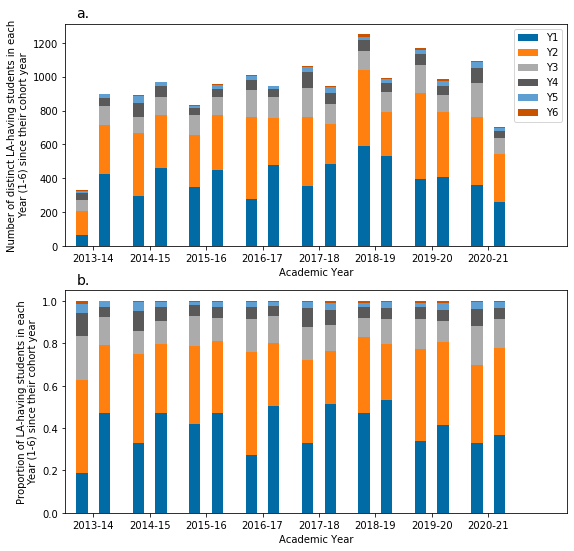

In [45]:
fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(9,9))
ax[0].bar(terms,num_LAstudents[0,:], width=2, label="Y1")
ax[0].bar(terms,num_LAstudents[1,:],bottom=np.sum(num_LAstudents[:1,:],0), width=2, label="Y2")
ax[0].bar(terms,num_LAstudents[2,:],bottom=np.sum(num_LAstudents[:2,:],0), width=2, label="Y3")
ax[0].bar(terms,num_LAstudents[3,:],bottom=np.sum(num_LAstudents[:3,:],0), width=2, label="Y4")
ax[0].bar(terms,num_LAstudents[4,:],bottom=np.sum(num_LAstudents[:4,:],0), width=2, label="Y5")
ax[0].bar(terms,num_LAstudents[5,:],bottom=np.sum(num_LAstudents[:5,:],0), width=2, label="Y6")
ax[0].set_xlim([2128,2217]); ax[0].legend()
ax[0].set_xticks([2133,2143,2153,2163,2173,2183,2193,2203])
ax[0].set_xticklabels(["2013-14","2014-15","2015-16","2016-17","2017-18","2018-19","2019-20","2020-21"])
ax[0].set_xlabel("Academic Year");
ax[0].set_ylabel("Number of distinct LA-having students in each\nYear (1-6) since their cohort year");
ax[0].text(2130,1350,"a.",fontsize=14);

ax[1].bar(terms,prc_LAstudents[0,:], width=2, label="Y1")
ax[1].bar(terms,prc_LAstudents[1,:],bottom=np.sum(prc_LAstudents[:1,:],0), width=2, label="Y2")
ax[1].bar(terms,prc_LAstudents[2,:],bottom=np.sum(prc_LAstudents[:2,:],0), width=2, label="Y3")
ax[1].bar(terms,prc_LAstudents[3,:],bottom=np.sum(prc_LAstudents[:3,:],0), width=2, label="Y4")
ax[1].bar(terms,prc_LAstudents[4,:],bottom=np.sum(prc_LAstudents[:4,:],0), width=2, label="Y5")
ax[1].bar(terms,prc_LAstudents[5,:],bottom=np.sum(prc_LAstudents[:5,:],0), width=2, label="Y6")
ax[1].set_xlim([2128,2217]); #ax[1].legend();
ax[1].set_xticks([2133,2143,2153,2163,2173,2183,2193,2203])
ax[1].set_xticklabels(["2013-14","2014-15","2015-16","2016-17","2017-18","2018-19","2019-20","2020-21"]);
ax[1].set_xlabel("Academic Year");
ax[1].set_ylabel("Proportion of LA-having students in each\nYear (1-6) since their cohort year");
ax[1].text(2130,1.08,"b.",fontsize=14);
plt.savefig('LAstudentBreakdownByYear.png')


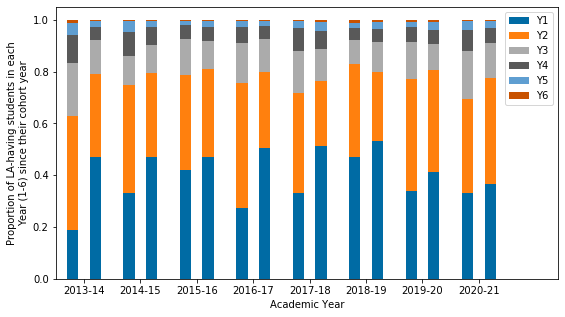

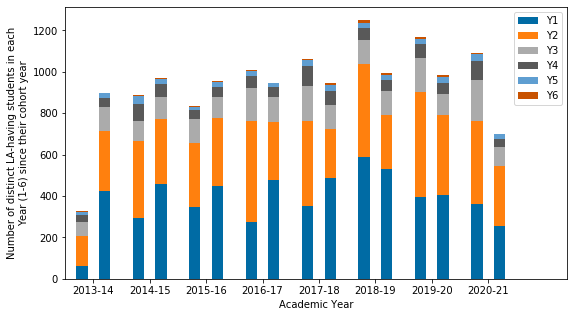

In [46]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(9,5))
plt.bar(terms,prc_LAstudents[0,:], width=2, label="Y1")
plt.bar(terms,prc_LAstudents[1,:],bottom=np.sum(prc_LAstudents[:1,:],0), width=2, label="Y2")
plt.bar(terms,prc_LAstudents[2,:],bottom=np.sum(prc_LAstudents[:2,:],0), width=2, label="Y3")
plt.bar(terms,prc_LAstudents[3,:],bottom=np.sum(prc_LAstudents[:3,:],0), width=2, label="Y4")
plt.bar(terms,prc_LAstudents[4,:],bottom=np.sum(prc_LAstudents[:4,:],0), width=2, label="Y5")
plt.bar(terms,prc_LAstudents[5,:],bottom=np.sum(prc_LAstudents[:5,:],0), width=2, label="Y6")
plt.xlim([2128,2217]); plt.legend();
plt.xticks([2133,2143,2153,2163,2173,2183,2193,2203],
           labels=["2013-14","2014-15","2015-16","2016-17","2017-18","2018-19","2019-20","2020-21"]);
plt.xlabel("Academic Year");
plt.ylabel("Proportion of LA-having students in each\nYear (1-6) since their cohort year");
plt.savefig('LAstudentBreakdownByYear_prc.png')

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(9,5))
plt.bar(terms,num_LAstudents[0,:], width=2, label="Y1")
plt.bar(terms,num_LAstudents[1,:],bottom=np.sum(num_LAstudents[:1,:],0), width=2, label="Y2")
plt.bar(terms,num_LAstudents[2,:],bottom=np.sum(num_LAstudents[:2,:],0), width=2, label="Y3")
plt.bar(terms,num_LAstudents[3,:],bottom=np.sum(num_LAstudents[:3,:],0), width=2, label="Y4")
plt.bar(terms,num_LAstudents[4,:],bottom=np.sum(num_LAstudents[:4,:],0), width=2, label="Y5")
plt.bar(terms,num_LAstudents[5,:],bottom=np.sum(num_LAstudents[:5,:],0), width=2, label="Y6")
plt.xlim([2128,2217]); plt.legend();
plt.xticks([2133,2143,2153,2163,2173,2183,2193,2203],
           labels=["2013-14","2014-15","2015-16","2016-17","2017-18","2018-19","2019-20","2020-21"]);
plt.xlabel("Academic Year");
plt.ylabel("Number of distinct LA-having students in each\nYear (1-6) since their cohort year");
plt.savefig('LAstudentBreakdownByYear_num.png')


Compute the numbers matrices:

In [47]:
mats_LA = {c : None for c in cohort_terms_full+cohort_terms_part}
mats_noLA = {c : None for c in cohort_terms_full+cohort_terms_part}
for c in cohort_terms_full+cohort_terms_part:
    mats_LA[c] = compute_matrix_tw(dfLAcoursestudents_LA,c)
    mats_noLA[c] = compute_matrix_orig(dfLAcoursestudents_noLA,c)

Numbers matrices for COS majors

In [48]:
mats_LA_cos = {c : None for c in cohort_terms_full+cohort_terms_part}
mats_noLA_cos = {c : None for c in cohort_terms_full+cohort_terms_part}
for c in cohort_terms_full+cohort_terms_part:
    mats_LA_cos[c] = compute_matrix_tw(dfLAcoursestudents_LA.loc[dfLAcoursestudents_LA.ID.isin(IDs_cos)],c)
    mats_noLA_cos[c] = compute_matrix_orig(dfLAcoursestudents_noLA.loc[dfLAcoursestudents_noLA.ID.isin(IDs_cos)],c)

Normalize them individually, since might want to look at differences from estimating using a single cohort vs all:

(full-data cohorts only)

Will get a divide-by-zero error for the normalization of the PHYS no-LA matrices for one of the cohort years. Highlights the importance of the ability of this approach to combine information across cohorts!

In [49]:
pmats_LA = {c : normalize(mats_LA[c]) for c in cohort_terms_full}
pmats_noLA = {c : normalize(mats_noLA[c]) for c in cohort_terms_full}

pmats_LA_cos = {c : normalize(mats_LA_cos[c]) for c in cohort_terms_full}
pmats_noLA_cos = {c : normalize(mats_noLA_cos[c]) for c in cohort_terms_full}

But the focus is probably on the entire combined matrix, so combine them, and normalize:

In [50]:
mats_LA["all"] = np.sum([mats_LA[c] for c in cohort_terms_full+cohort_terms_part], axis=0)
pmats_LA["all"] = normalize(mats_LA["all"])
mats_LA["full"] = np.sum([mats_LA[c] for c in cohort_terms_full], axis=0)
pmats_LA["full"] = normalize(mats_LA["full"])

mats_noLA["all"] = np.sum([mats_noLA[c] for c in cohort_terms_full+cohort_terms_part], axis=0)
pmats_noLA["all"] = normalize(mats_noLA["all"])
mats_noLA["full"] = np.sum([mats_noLA[c] for c in cohort_terms_full], axis=0)
pmats_noLA["full"] = normalize(mats_noLA["full"])

# for COS majors
mats_LA_cos["all"] = np.sum([mats_LA_cos[c] for c in cohort_terms_full+cohort_terms_part], axis=0)
pmats_LA_cos["all"] = normalize(mats_LA_cos["all"])
mats_LA_cos["full"] = np.sum([mats_LA_cos[c] for c in cohort_terms_full], axis=0)
pmats_LA_cos["full"] = normalize(mats_LA_cos["full"])

mats_noLA_cos["all"] = np.sum([mats_noLA_cos[c] for c in cohort_terms_full+cohort_terms_part], axis=0)
pmats_noLA_cos["all"] = normalize(mats_noLA_cos["all"])
mats_noLA_cos["full"] = np.sum([mats_noLA_cos[c] for c in cohort_terms_full], axis=0)
pmats_noLA_cos["full"] = normalize(mats_noLA_cos["full"])

### Compare Y1 retention:

Y1 retention is notably higher among students who have had LAs than those who did not. Full-data only vs using all cohorts (including partial data) don't have much of an effect.

The matrices at the top are for all (full+partial) cohorts

In [51]:
print("=======================================================")
print("All students who touched LA-assisted courses:\n")
print("LAs:")
printmat(mats_LA["all"])
print("\nNo LAs:")
printmat(mats_noLA["all"])

print("\n\n=======================================================")
print("All students who touched LA-assisted courses, and ever had a COS major:\n")
print("LAs:")
printmat(mats_LA_cos["all"])
print("\nNo LAs:")
printmat(mats_noLA_cos["all"])

All students who touched LA-assisted courses:

LAs:
N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1     3903       359           0
2     5212       405           3
3     4472       167          50
4     2704        98         973
5      461        65        1638
6                168         311

No LAs:
N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1     8605      1190           1
2     6684       671           6
3     5348       254          97
4     2789       122        1428
5      569        59        1528
6                221         348


All students who touched LA-assisted courses, and ever had a COS major:

LAs:
N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1      895       116           0
2      918        87           2
3      750        44          25
4      229        27         362
5       58         5         129
6                 21          37

No LAs:
N   YN->N+1  YN->DropOut  YN->Grad
-----------

In [52]:
print("=======================================================")
print("All students who touched LA-assisted courses:\n")
print("W/ LAs:")
printmat(pmats_LA["all"])
print("\nNo LAs:")
printmat(pmats_noLA["all"])
print()
print("Using Full-data cohorts only")
print("  Y1 retention among LA-having students {:0.3f}".format(pmats_LA["full"][0,1]))
print("  Y1 retention among students w/ no LAs {:0.3f}".format(pmats_noLA["full"][0,1]))
print("Using Full and Partial-data cohorts")
print("  Y1 retention among LA-having students {:0.3f}".format(pmats_LA["all"][0,1]))
print("  Y1 retention among students w/ no LAs {:0.3f}".format(pmats_noLA["all"][0,1]))

print("\n\n=======================================================")
print("All students who touched LA-assisted courses, and ever had a COS major:\n")
print("W/ LAs:")
printmat(pmats_LA_cos["all"])
print("\nNo LAs:")
printmat(pmats_noLA_cos["all"])
print()
print("Using Full-data cohorts only")
print("  Y1 retention among LA-having students {:0.3f}".format(pmats_LA_cos["full"][0,1]))
print("  Y1 retention among students w/ no LAs {:0.3f}".format(pmats_noLA_cos["full"][0,1]))
print("Using Full and Partial-data cohorts")
print("  Y1 retention among LA-having students {:0.3f}".format(pmats_LA_cos["all"][0,1]))
print("  Y1 retention among students w/ no LAs {:0.3f}".format(pmats_noLA_cos["all"][0,1]))

All students who touched LA-assisted courses:

W/ LAs:
N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1    0.916      0.084         0.0
2    0.927      0.072       0.001
3    0.954      0.036       0.011
4    0.716      0.026       0.258
5    0.213       0.03       0.757
6               0.351       0.649

No LAs:
N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1    0.878      0.121         0.0
2    0.908      0.091       0.001
3    0.938      0.045       0.017
4    0.643      0.028       0.329
5    0.264      0.027       0.709
6               0.388       0.612

Using Full-data cohorts only
  Y1 retention among LA-having students 0.927
  Y1 retention among students w/ no LAs 0.869
Using Full and Partial-data cohorts
  Y1 retention among LA-having students 0.916
  Y1 retention among students w/ no LAs 0.878


All students who touched LA-assisted courses, and ever had a COS major:

W/ LAs:
N   YN->N+1  YN->DropOut  YN->Grad
--------------------

### Compare 4Y graduation rate:

In [53]:
n = 4

print("=======================================================")
print("All students who touched LA-assisted courses:\n")
print("Using only Full-data Cohorts:")
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmats_LA["full"],n), np.linalg.matrix_power(pmats_noLA["full"],n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))

print("\nUsing Full and Partial-data Cohorts:")
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmats_LA["all"],n), np.linalg.matrix_power(pmats_noLA["all"],n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))

print("\n\n=======================================================")
print("All students who touched LA-assisted courses, and ever had a COS major:\n")
print("Using only Full-data Cohorts:")
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmats_LA_cos["full"],n), np.linalg.matrix_power(pmats_noLA_cos["full"],n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))

print("\nUsing Full and Partial-data Cohorts:")
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmats_LA_cos["all"],n), np.linalg.matrix_power(pmats_noLA_cos["all"],n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))


All students who touched LA-assisted courses:

Using only Full-data Cohorts:
LAs:
 [0.    0.    0.    0.    0.613 0.    0.17  0.216]
No LAs:
 [0.    0.    0.    0.    0.48  0.    0.27  0.251]
4Y graduate rate among LA-having students 0.216
4Y graduate rate among students w/ no LAs 0.251

Using Full and Partial-data Cohorts:
LAs:
 [0.    0.    0.    0.    0.58  0.    0.202 0.218]
No LAs:
 [0.    0.    0.    0.    0.481 0.    0.258 0.261]
4Y graduate rate among LA-having students 0.218
4Y graduate rate among students w/ no LAs 0.261


All students who touched LA-assisted courses, and ever had a COS major:

Using only Full-data Cohorts:
LAs:
 [0.    0.    0.    0.    0.302 0.    0.249 0.449]
No LAs:
 [0.    0.    0.    0.    0.335 0.    0.335 0.33 ]
4Y graduate rate among LA-having students 0.449
4Y graduate rate among students w/ no LAs 0.330

Using Full and Partial-data Cohorts:
LAs:
 [0.    0.    0.    0.    0.274 0.    0.267 0.459]
No LAs:
 [0.    0.    0.    0.    0.325 0.    0.325 0

### Compare 6Y graduation rate:

In [54]:
n = 6

print("=======================================================")
print("All students who touched LA-assisted courses:\n")
print("Using only Full-data Cohorts:")
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmats_LA["full"],n), np.linalg.matrix_power(pmats_noLA["full"],n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))

print("\nUsing Full and Partial-data Cohorts:")
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmats_LA["all"],n), np.linalg.matrix_power(pmats_noLA["all"],n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))

print("\n\n=======================================================")
print("All students who touched LA-assisted courses, and ever had a COS major:\n")
print("Using only Full-data Cohorts:")
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmats_LA_cos["full"],n), np.linalg.matrix_power(pmats_noLA_cos["full"],n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))

print("\nUsing Full and Partial-data Cohorts:")
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmats_LA_cos["all"],n), np.linalg.matrix_power(pmats_noLA_cos["all"],n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))


All students who touched LA-assisted courses:

Using only Full-data Cohorts:
LAs:
 [0.    0.    0.    0.    0.    0.    0.235 0.765]
No LAs:
 [0.    0.    0.    0.    0.    0.    0.332 0.668]
6Y graduate rate among LA-having students 0.765
6Y graduate rate among students w/ no LAs 0.668

Using Full and Partial-data Cohorts:
LAs:
 [0.    0.    0.    0.    0.    0.    0.262 0.738]
No LAs:
 [0.    0.    0.    0.    0.    0.    0.321 0.679]
6Y graduate rate among LA-having students 0.738
6Y graduate rate among students w/ no LAs 0.679


All students who touched LA-assisted courses, and ever had a COS major:

Using only Full-data Cohorts:
LAs:
 [0.   0.   0.   0.   0.   0.   0.29 0.71]
No LAs:
 [0.    0.    0.    0.    0.    0.    0.391 0.609]
6Y graduate rate among LA-having students 0.710
6Y graduate rate among students w/ no LAs 0.609

Using Full and Partial-data Cohorts:
LAs:
 [0.    0.    0.    0.    0.    0.    0.304 0.696]
No LAs:
 [0.    0.    0.    0.    0.    0.    0.379 0.621]
6Y

<br>

---

<h1 style="font-size:24pt;color:purple">Restricting to specific high-DFW COS courses</h1>

In [55]:
cohort_terms = cohort_terms_full+cohort_terms_part

def matrices_for_course_list(courses, LAclass_tups, df, cohort_terms):
    # input: courses (list of (SUBJ, CRS#) tuples), LAclass_tups, df, list of terms to use

    IDs_these_courses, IDs_LAs_these_courses = set(), set()
    LA_tups_these_courses = []
    for c in courses:
        IDs_these_courses = set.union(IDs_these_courses,
                                      df.loc[(df.subject==c[0]) & (df.catalog_nbr==c[1]),"ID"].unique())
        this_class = [LAclass_tups[k][0]==c[0] and LAclass_tups[k][1]==c[1] for k in range(len(LAclass_tups))]
        if np.sum(this_class) > 0:
            LA_tups_this_class = [LAclass_tups[k] for k in [i for i, x in enumerate(this_class) if x]]
            LA_tups_these_courses = LA_tups_these_courses + list(LA_tups_this_class)
            for cs in LA_tups_this_class:
                IDs_LAs_these_courses = set.union(IDs_LAs_these_courses,
                                                  df.loc[(df.subject==cs[0]) & (df.catalog_nbr==cs[1]) & 
                                                         (df.class_section==cs[2]) & (df.Term==cs[3]),"ID"].unique())
    # restrict to only the list of courses
    dfC_all = df.loc[(df.ID.isin(IDs_these_courses))]
    dfC_LA = df.loc[(df.ID.isin(IDs_LAs_these_courses))]
    dfC_noLA = df.loc[(~df.ID.isin(IDs_LAs_these_courses))]

    # numbers matrices for these courses
    mats_LA_these_courses = {c : None for c in cohort_terms}
    mats_noLA_these_courses = {c : None for c in cohort_terms}
    for c in cohort_terms:
        mats_LA_these_courses[c] = compute_matrix_tw(dfC_LA,c)
        mats_noLA_these_courses[c] = compute_matrix_orig(dfC_noLA,c)

    # sum across cohort terms and normalize    
    mats_LA_these_courses["all"] = np.sum([mats_LA_these_courses[c] for c in cohort_terms], axis=0)
    pmats_LA_these_courses = normalize(mats_LA_these_courses["all"])
    mats_noLA_these_courses["all"] = np.sum([mats_noLA_these_courses[c] for c in cohort_terms], axis=0)
    pmats_noLA_these_courses = normalize(mats_noLA_these_courses["all"])

    return (pmats_LA_these_courses, pmats_noLA_these_courses, mats_LA_these_courses, mats_noLA_these_courses)

<br>

### High-DFW COS courses

Including:
* PHYS: 111, 112, 211A, 211, 212
* MATH: 111, 171, 182A, 211
  * Note that there are no instances of MATH 172, 181(A), or 182 using LAs.
  * There is a single instance of MATH 182A using an LA.
  * Results without MATH 211 is below this. However, there's an overall DFW rate of 25% in that course, between Fall 2013 and Fall 2019 (see further below)
  
Y1 retention:
* Among students who have LAs in this set of courses: 97%
* Non-LA students in this same set of courses: 87%

In [56]:
courses = [("PHYS","111"),("PHYS","112"),("PHYS","211"),("PHYS","211A"),("PHYS","212"),
           ("MATH","111"), ("MATH","171"),("MATH","182A"),("MATH","211")]
pmat_LA_dfw, pmat_noLA_dfw, mats_LA_dfw, mats_noLA_dfw = matrices_for_course_list(courses,
                                                                                  LAclass_tups, df, cohort_terms)
# Y1 retention
printmat(pmat_LA_dfw)
printmat(pmat_noLA_dfw)
# 4-year grad rate
n=4
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmat_LA_dfw,n), np.linalg.matrix_power(pmat_noLA_dfw,n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having high-DFW COS course students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among high-DFW COS course students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))
# 6-year grad rate
n=6
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmat_LA_dfw,n), np.linalg.matrix_power(pmat_noLA_dfw,n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having high-DFW COS course students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among high-DFW COS course students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))

print("\n", int(mats_LA_dfw["all"][0,1]), "students starting in Y1 with LA in a high-DFW COS course")

N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1    0.974      0.026         0.0
2    0.945      0.055         0.0
3    0.967       0.03       0.003
4    0.817      0.021       0.162
5    0.225      0.037       0.738
6               0.329       0.671
N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1    0.866      0.134         0.0
2    0.912      0.087       0.001
3    0.938      0.043       0.019
4    0.544      0.029       0.427
5    0.251      0.027       0.722
6               0.403       0.597
LAs:
 [0.    0.    0.    0.    0.727 0.    0.126 0.147]
No LAs:
 [0.    0.    0.    0.    0.403 0.    0.264 0.332]
4Y graduate rate among LA-having high-DFW COS course students 0.147
4Y graduate rate among high-DFW COS course students w/ no LAs 0.332
LAs:
 [0.    0.    0.    0.    0.    0.    0.206 0.794]
No LAs:
 [0.    0.    0.    0.    0.    0.    0.316 0.684]
6Y graduate rate among LA-having high-DFW COS course students 0.794
6Y graduate rate a

<br>

### Confidence intervals for difference in proportions

$$\hat{p}_1 - \hat{p}_2 \pm z_{\alpha/2} \sqrt{\dfrac{\hat{p}_1(1-\hat{p}_1)}{n_1} + \dfrac{\hat{p}_2(1-\hat{p}_2)}{n_2}}$$

For a transition probability in row $i$, the sample sizes $n_1$ and $n_2$ should be the total number of students from row $i$.

In [57]:
z_10 = stats.norm.ppf(1-0.1/2)
z_05 = stats.norm.ppf(1-0.05/2)
z_01 = stats.norm.ppf(1-0.01/2)

#### For year-to-year transitions

In [58]:
significances = np.zeros(pmat_LA_dfw.shape)
for i in range(pmat_LA_dfw.shape[0]):
    for j in range(pmat_LA_dfw.shape[1]):
        p1, p2 = pmat_LA_dfw[i,j], pmat_noLA_dfw[i,j]
        n1, n2 = np.sum(mats_LA_dfw["all"][i,:]), np.sum(mats_noLA_dfw["all"][i,:])
        pdiff = p1-p2
        pdiff_std = np.sqrt( p1*(1-p1)/n1 + p2*(1-p2)/n2 )
        ci_99 = [pdiff + pm*z_01*pdiff_std for pm in [-1,1]]
        if np.prod(ci_99) > 0:
            significances[i,j] = 0.01
        else:
            ci_95 = [pdiff + pm*z_05*pdiff_std for pm in [-1,1]]
            if np.prod(ci_95) > 0:
                significances[i,j] = 0.05
            else:
                ci_90 = [pdiff + pm*z_10*pdiff_std for pm in [-1,1]]
                if np.prod(ci_90) > 0:
                    significances[i,j] = 0.1

In [59]:
significances    

array([[0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.01],
       [0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.01, 0.01],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.05, 0.01],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.1 , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.05],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

<br>

#### Significance for the 4Y and 6Y graduation rates

These are the proportions moving from Y1 to Grad states in 4 or 6 steps. So the denominators for these proportions are the Y1 totals.

In [60]:
i,j = 0,7

n=4
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmat_LA_dfw,n), np.linalg.matrix_power(pmat_noLA_dfw,n)
p1, p2 = newmats_LA[i,j], newmats_noLA[i,j]
n1, n2 = np.sum(mats_LA_dfw["all"][i,:]), np.sum(mats_noLA_dfw["all"][i,:])
pdiff = p1-p2
pdiff_std = np.sqrt( p1*(1-p1)/n1 + p2*(1-p2)/n2 )
ci_99 = [pdiff + pm*z_01*pdiff_std for pm in [-1,1]]
if np.prod(ci_99) > 0:
    print("4Y grad rate difference significant at 1%")
else:
    ci_95 = [pdiff + pm*z_05*pdiff_std for pm in [-1,1]]
    if np.prod(ci_95) > 0:
        print("4Y grad rate difference significant at 5%")
    else:
        ci_90 = [pdiff + pm*z_10*pdiff_std for pm in [-1,1]]
        if np.prod(ci_90) > 0:
            print("4Y grad rate difference significant at 10%")
        else:
            print("4Y grad rate difference NOT significant")

n=6
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmat_LA_dfw,n), np.linalg.matrix_power(pmat_noLA_dfw,n)
p1, p2 = newmats_LA[i,j], newmats_noLA[i,j]
n1, n2 = np.sum(mats_LA_dfw["all"][i,:]), np.sum(mats_noLA_dfw["all"][i,:])
pdiff = p1-p2
pdiff_std = np.sqrt( p1*(1-p1)/n1 + p2*(1-p2)/n2 )
ci_99 = [pdiff + pm*z_01*pdiff_std for pm in [-1,1]]
if np.prod(ci_99) > 0:
    print("6Y grad rate difference significant at 1%")
else:
    ci_95 = [pdiff + pm*z_05*pdiff_std for pm in [-1,1]]
    if np.prod(ci_95) > 0:
        print("6Y grad rate difference significant at 5%")
    else:
        ci_90 = [pdiff + pm*z_10*pdiff_std for pm in [-1,1]]
        if np.prod(ci_90) > 0:
            print("6Y grad rate difference significant at 10%")
        else:
            print("6Y grad rate difference NOT significant")

4Y grad rate difference significant at 1%
6Y grad rate difference significant at 1%


<br>

#### Calculate numbers of students in each of the courses, and numbers of sections

In [61]:
student_counts_LA, section_counts_LA = np.zeros((len(courses),len(terms))), np.zeros((len(courses),len(terms)))
student_counts_noLA, section_counts_noLA = np.zeros((len(courses),len(terms))), np.zeros((len(courses),len(terms)))
total_no_student = 0
for t in terms:
    ti = list(terms).index(t)
    for c in courses:
        ci = courses.index(c)
        subj = c[0]
        crs = c[1]
        dfSubset = df.loc[(df.subject==subj) & (df.catalog_nbr==crs) & (df.Term==t)].copy()
        # LA sections of this course this term, excluding recitation, lab, and "splits"
        LA_tups_this_class = [tup for tup in LAclass_tups if (tup[0]==subj and tup[1]==crs and tup[3]==t and
                                                              "L" not in tup[2] and "R" not in tup[2] and "S" not in tup[2])]
        # check that they actually have students in them
        num_no_students = 0
        LA_sections = []
        for tup in LA_tups_this_class:
            num_students_this_section = len(dfSubset.loc[(dfSubset.class_section==tup[2]),"ID"].unique())
            student_counts_LA[ci,ti] += num_students_this_section
            LA_sections.append(tup[2])
            if num_students_this_section==0:
                num_no_students += 1
                total_no_student += 1
        section_counts_LA[ci,ti] = len(LA_tups_this_class) - num_no_students
        # non-LA sections of this course, this term, ... 
        sections_this_term = dfSubset.loc[(dfSubset["class_section"].str.find("S")==-1) &
                                          (dfSubset["class_section"].str.find("R")==-1) & 
                                          (dfSubset["class_section"].str.find("L")==-1),"class_section"].unique()
        noLA_sections = list(set.difference(set(sections_this_term), set(LA_sections)))
        section_counts_noLA[ci,ti] = len(noLA_sections) 
        # non-LA students this course
        for sec in noLA_sections:
            student_counts_noLA[ci,ti] += len(dfSubset.loc[(dfSubset["class_section"]==sec),"ID"].unique())
        

In [62]:
csv_to_write = []
for c in courses:
    ci = courses.index(c)
    row_str_LA = c[0]+c[1]+" LA"
    row_str_noLA = c[0]+c[1]+" no-LA"
    for t in terms:
        ti = list(terms).index(t)
        row_str_LA = row_str_LA + "," + str(int(student_counts_LA[ci,ti])) + " (" + str(int(section_counts_LA[ci,ti])) + ")"
        row_str_noLA = row_str_noLA + "," + str(int(student_counts_noLA[ci,ti])) + " (" + str(int(section_counts_noLA[ci,ti])) + ")"
    row_str_LA = row_str_LA + "," + str(int(np.sum(student_counts_LA[ci,:]))) + " (" + str(int(np.sum(section_counts_LA[ci,:]))) + ")"
    row_str_noLA = row_str_noLA + "," + str(int(np.sum(student_counts_noLA[ci,:]))) + " (" + str(int(np.sum(section_counts_noLA[ci,:]))) + ")"
    csv_to_write.append(row_str_LA)
    csv_to_write.append(row_str_noLA)


In [63]:
pd.DataFrame(csv_to_write).to_csv("counts.csv")

In [64]:
np.sum(student_counts_LA), np.sum(student_counts_noLA)

(6130.0, 26970.0)

<br>

### Same, subsetting down to only students who ever had a COS major

In [65]:
pmat_LA_dfw_cos, pmat_noLA_dfw_cos, mats_LA_dfw_cos, mats_noLA_dfw_cos = matrices_for_course_list(courses, 
                                                                                                  LAclass_tups, 
                                                                                                  df.loc[df.ID.isin(IDs_cos)], 
                                                                                                  cohort_terms)
# Y1 retention
printmat(pmat_LA_dfw_cos)
printmat(pmat_noLA_dfw_cos)
# 4-year grad rate
n=4
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmat_LA_dfw_cos,n), np.linalg.matrix_power(pmat_noLA_dfw_cos,n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having high-DFW COS course students (COS-only) {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among high-DFW COS course students w/ no LAs (COS-only) {:0.3f}".format(n,newmats_noLA[0,7]))
# 6-year grad rate
n=6
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmat_LA_dfw_cos,n), np.linalg.matrix_power(pmat_noLA_dfw_cos,n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having high-DFW COS course students (COS-only) {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among high-DFW COS course students w/ no LAs (COS-only) {:0.3f}".format(n,newmats_noLA[0,7]))

print("\n", int(mats_LA_dfw_cos["all"][0,1]), "students starting in Y1 with LA in a high-DFW COS course (COS-only)")

N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1     0.97       0.03         0.0
2    0.935      0.065         0.0
3    0.946      0.038       0.017
4    0.446      0.027       0.527
5    0.238      0.032        0.73
6               0.533       0.467
N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1    0.867      0.132       0.001
2     0.91      0.088       0.002
3    0.909      0.058       0.032
4    0.377      0.047       0.576
5    0.312      0.016       0.672
6                0.39        0.61
LAs:
 [0.    0.    0.    0.    0.383 0.    0.15  0.467]
No LAs:
 [0.    0.    0.    0.    0.27  0.    0.288 0.442]
4Y graduate rate among LA-having high-DFW COS course students (COS-only) 0.467
4Y graduate rate among high-DFW COS course students w/ no LAs (COS-only) 0.442
LAs:
 [0.    0.    0.    0.    0.    0.    0.211 0.789]
No LAs:
 [0.    0.    0.    0.    0.    0.    0.325 0.675]
6Y graduate rate among LA-having high-DFW COS course students (C

Significances for year-to-year transitions:

In [66]:
significances_cos = np.zeros(pmat_LA_dfw_cos.shape)
for i in range(pmat_LA_dfw_cos.shape[0]):
    for j in range(pmat_LA_dfw_cos.shape[1]):
        p1, p2 = pmat_LA_dfw_cos[i,j], pmat_noLA_dfw_cos[i,j]
        n1, n2 = np.sum(mats_LA_dfw_cos["all"][i,:]), np.sum(mats_noLA_dfw_cos["all"][i,:])
        pdiff = p1-p2
        pdiff_std = np.sqrt( p1*(1-p1)/n1 + p2*(1-p2)/n2 )
        ci_99 = [pdiff + pm*z_01*pdiff_std for pm in [-1,1]]
        if np.prod(ci_99) > 0:
            significances_cos[i,j] = 0.01
        else:
            ci_95 = [pdiff + pm*z_05*pdiff_std for pm in [-1,1]]
            if np.prod(ci_95) > 0:
                significances_cos[i,j] = 0.05
            else:
                ci_90 = [pdiff + pm*z_10*pdiff_std for pm in [-1,1]]
                if np.prod(ci_90) > 0:
                    significances_cos[i,j] = 0.1
print(significances_cos)

[[0.   0.01 0.   0.   0.   0.   0.01 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.05 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.1  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]]


Significances for 4y and 6y graduation rates:

In [67]:
i,j = 0,7

n=4
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmat_LA_dfw_cos,n), np.linalg.matrix_power(pmat_noLA_dfw_cos,n)
p1, p2 = newmats_LA[i,j], newmats_noLA[i,j]
n1, n2 = np.sum(mats_LA_dfw_cos["all"][i,:]), np.sum(mats_noLA_dfw_cos["all"][i,:])
pdiff = p1-p2
pdiff_std = np.sqrt( p1*(1-p1)/n1 + p2*(1-p2)/n2 )
ci_99 = [pdiff + pm*z_01*pdiff_std for pm in [-1,1]]
if np.prod(ci_99) > 0:
    print("4Y grad rate difference significant at 1%")
else:
    ci_95 = [pdiff + pm*z_05*pdiff_std for pm in [-1,1]]
    if np.prod(ci_95) > 0:
        print("4Y grad rate difference significant at 5%")
    else:
        ci_90 = [pdiff + pm*z_10*pdiff_std for pm in [-1,1]]
        if np.prod(ci_90) > 0:
            print("4Y grad rate difference significant at 10%")
        else:
            print("4Y grad rate difference NOT significant")

n=6
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmat_LA_dfw_cos,n), np.linalg.matrix_power(pmat_noLA_dfw_cos,n)
p1, p2 = newmats_LA[i,j], newmats_noLA[i,j]
n1, n2 = np.sum(mats_LA_dfw_cos["all"][i,:]), np.sum(mats_noLA_dfw_cos["all"][i,:])
pdiff = p1-p2
pdiff_std = np.sqrt( p1*(1-p1)/n1 + p2*(1-p2)/n2 )
ci_99 = [pdiff + pm*z_01*pdiff_std for pm in [-1,1]]
if np.prod(ci_99) > 0:
    print("6Y grad rate difference significant at 1%")
else:
    ci_95 = [pdiff + pm*z_05*pdiff_std for pm in [-1,1]]
    if np.prod(ci_95) > 0:
        print("6Y grad rate difference significant at 5%")
    else:
        ci_90 = [pdiff + pm*z_10*pdiff_std for pm in [-1,1]]
        if np.prod(ci_90) > 0:
            print("6Y grad rate difference significant at 10%")
        else:
            print("6Y grad rate difference NOT significant")

4Y grad rate difference NOT significant
6Y grad rate difference significant at 1%
